# Virtual linac guide

- [Introduction](#Introduction)
- [Helper functions](#Helper-functions)
- [AWS (Amazon web service)](#AWS)
- [VirtuaLinac API](#VirtuaLinac-API)
- [Plot .dose data](#Plot-.dose-data)
- [Calculation with my phantom](#Calculation-with-my-phantom)
- [Terminate](#Terminate)

# Introduction

ALWAYS NEED TO EDIT INSTANCE SECURITY GROUP > INCOMING > HTTP > FROM MY IP

Follow guide on http://radiotherapyresearchtools.com/doc/api_tutorial.html

Bitbucket code https://bitbucket.org/darens/virtualinac

In [2]:
%load_ext watermark
%watermark -a 'Robin Cole' -u -d -v -p numpy,pandas,matplotlib

Robin Cole 
last updated: 2016-09-23 

CPython 3.5.2
IPython 4.2.0

numpy 1.11.1
pandas 0.18.1
matplotlib 1.5.1


In [46]:
import boto3
import requests
import re
from bs4 import BeautifulSoup
import vl_api_helper as vl   # Daren helper files
from time import localtime, strftime  # to print time
import plotdose as vlplt
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pprint
import os
import pandas as pd
%matplotlib inline

# Helper functions

In [4]:
def get_jobs():
    r = requests.get(url + '/usage') 
    for line in r.text.split('\n'):
        if 'Number of jobs' in line:
            print(url + '/usage') 
            print(line)
            print(strftime("%H:%M:%S", localtime()))

In [5]:
def print_files(url):    # Helper function to print list of files on server
    resp = requests.get(url + '/phspfiles') # get page with list of output files
    soup = BeautifulSoup(resp.text, 'html.parser')   
    my_list = []
    for link in soup.find_all('a'):   # get all links
        my_list.append(link.get('href'))
    results = [k for k in my_list if '/vl_files/' in k]  # get only links from vl_files
    for item in results:
        pprint.pprint(re.sub('/vl_files/', '', item))  # use pprint and strip vl_files

In [6]:
def download_file(url, file):    # my own helper function to download files
    r = requests.get(url + '/vl_files/' + file, stream=True)
    f = open(file, 'wb')     # use 'wb' write binary
    f.write(r.content)
    f.close()
    print(file, " downloaded at ", strftime("%H:%M:%S", localtime()), " File size (Bytes)", os.path.getsize(file))

# AWS

Logon to AWS, start virtualinac instance, edit security group to accept incoming HTTP

In [9]:
ec2=boto3.resource('ec2')
instances = ec2.instances.filter(Filters=
    [{'Name': 'instance-state-name', 'Values': ['running'] }])

In [10]:
dns_names = []
for instance in instances:
        #print(instance.public_dns_name)
        dns_names.append(instance.public_dns_name)
url = 'http://' + dns_names[0]
print(url)

http://ec2-54-172-91-56.compute-1.amazonaws.com


# VirtuaLinac API

In [18]:
# all sizes in mm
rc_23_9_10x10_v1_web = {
    'filename'     : 'rc_23_9_10x10_v1_web',
    'code_version' : 0,
    'physics_list' : 0,
    'beam_type'    : 0,
    'range_cut' : 10,
    'energy'       : 6.84,
    'energy_spread' : 0.6,
    'spot_size_x'  : 0.7,
    'spot_size_y'  : 0.7,
    'beam_divergence_x' : 0.0,
    'beam_divergence_y' : 0.0,
    'jaw_position_y1' : -5,   # cm
    'jaw_position_y2' :  5,
    'jaw_position_x1' : -5,
    'jaw_position_x2' :  5,
    'phantom_bool' : 'True',     # Create the phantom? if None then uses phantom file
    'phantom_size_x' : 500,
    'phantom_size_y' : 500,
    'phantom_size_z' : 400,
    'phantom_voxels_x' : 125,
    'phantom_voxels_y' : 125,
    'phantom_voxels_z' : 100,
    'phantom_position_x' : 0,
    'phantom_position_y' : 0,
    'phantom_position_z' : -20,    # distances in cm relative to isocentre.  
    'incident_particles' : 1000000,    
    'brem_splitting' : None,   # increased from none
    'splitting_factor' : None,
    'phsp_record'  : None
}

.dictionary file lists all calculation parameters

In [26]:
#r = requests.post(url, params=rc_23_9_10x10_v1)   # Submit calculation NOT WORKING - use web page

In [28]:
get_jobs()

http://ec2-54-172-91-56.compute-1.amazonaws.com/usage
<p><b>Number of jobs:</b> 1 </p>
10:45:15


In [30]:
print_files(url) # On calculation completion, get files 

'06e_x.dat'
'06e_z.dat'
'12e_x.dat'
'12e_z.dat'
'cylinder.phantom'
'gantry.xml'
'rc_23_9_10x10_v1_web.dictionary'
'rc_23_9_10x10_v1_web.dose'
'rc_23_9_10x10_v1_web.mac'
'rc_23_9_10x10_v1_web.output'


In [32]:
filename = 'rc_23_9_10x10_v1_web'

download_file(url, filename+'.dictionary') # download .dose file
download_file(url, filename+'.output') # download .dose file
download_file(url, filename+'.dose') # download .dose file
download_file(url, filename+'.mac') # download .dose file

rc_23_9_10x10_v1_web.dictionary  downloaded at  15:08:08  File size (Bytes) 1440
rc_23_9_10x10_v1_web.output  downloaded at  15:08:08  File size (Bytes) 82864
rc_23_9_10x10_v1_web.dose  downloaded at  15:08:10  File size (Bytes) 1160933
rc_23_9_10x10_v1_web.mac  downloaded at  15:08:10  File size (Bytes) 1425


# Plot .dose Pdd data

Load some golden beam data for comparison

In [87]:
dd = pd.read_csv('Truebeam_6x_pdd_golden_data.csv')

Use vlplt.plotdose() to get data. Don't use for plotting

In [63]:
vlplt.plotdose('rc_23_9_10x10_v1_web.dose', xplot=25, yplot=25, zplot=20, plotdir='z', showGraph=False, output_file=True)   # xplot = Number of bins?

phantom size [mm]: 500.0 500.0 400.0
Voxels to plot. xplot: 25 yplot: 25 zplot: 20
Number of voxels in phantom.  nx: 50 ny: 50 nz: 40
i_max: 1


Compare golden beam and virtuaLinac data

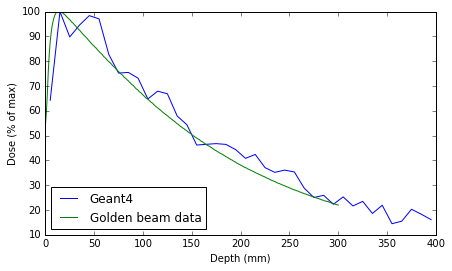

In [114]:
z_plot = np.genfromtxt('rc_23_9_10x10_v1_web.z.25_25_20.plt')  # load the data produced by vlplt.plotdose()
z_plot[:,1] = 100.0*z_plot[:,1]/z_plot[:,1].max()              # normalise

plt.figure(figsize=(7,4))
plt.plot(z_plot[:,0], z_plot[:,1], label='Geant4')             # plot the virtuaLinac data
plt.plot(dd['Depth [cm]']*10.0, dd['10x10cm2'], label='Golden beam data')  

plt.ylabel('Dose (% of max)')
plt.xlabel('Depth (mm)')
plt.legend(loc=3)
plt.show()

# Plot .dose profile data

Get the profile data using vlplt.plotdose()

In [101]:
vlplt.plotdose('rc_23_9_10x10_v1_web.dose', xplot=25, yplot=25, zplot=10, plotdir='x', showGraph=False, output_file=True)   # xplot = Number of bins?

phantom size [mm]: 500.0 500.0 400.0
Voxels to plot. xplot: 25 yplot: 25 zplot: 10
Number of voxels in phantom.  nx: 50 ny: 50 nz: 40


Import our golden beam data

In [90]:
profile = pd.read_csv('Truebeam_6x_profile_10x10_at10cm_golden_data.csv')

In [112]:
profile = profile.fillna(value=0.0)  # replace Nan with zero
# profile.head()

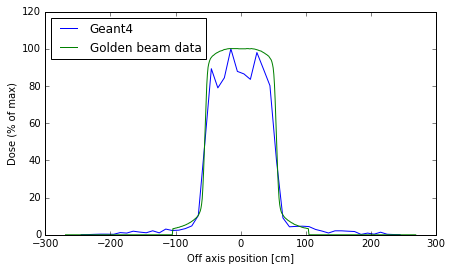

In [115]:
profile_plot = np.genfromtxt('rc_23_9_10x10_v1_web.x.25_25_10.plt')  # load the data produced by vlplt.plotdose()
profile_plot[:,1] = 100.0*profile_plot[:,1]/profile_plot[:,1].max()              # normalise

plt.figure(figsize=(7,4))
plt.plot(profile_plot[:,0], profile_plot[:,1], label='Geant4')             # plot the virtuaLinac data
plt.plot(profile['Off axis position [cm]']*10.0, profile['Field Size: 10x10 cm2'], label='Golden beam data')   # golden beam

plt.ylabel('Dose (% of max)')
plt.xlabel('Off axis position [cm]')
plt.legend(loc=2)
plt.show()

<hr>

# To do, 2D plots

phantom size [mm]: 500.0 500.0 400.0
Voxels to plot. xplot: 25 yplot: 25 zplot: 20
Number of voxels in phantom.  nx: 50 ny: 50 nz: 40


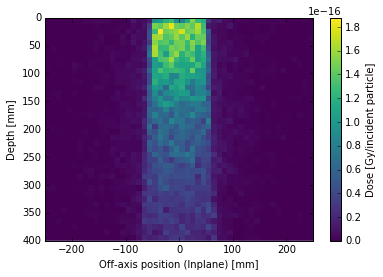

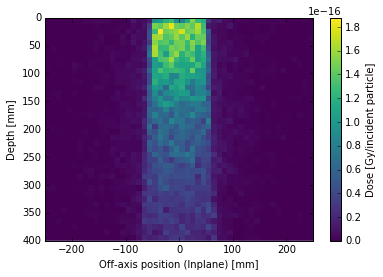

In [84]:
vlplt.plotdose('rc_23_9_10x10_v1_web.dose', xplot=25, yplot=25, zplot=20, plotdir='x', dimension=2) 

phantom size [mm]: 500.0 500.0 400.0
Voxels to plot. xplot: 25 yplot: 25 zplot: 6
Number of voxels in phantom.  nx: 50 ny: 50 nz: 40


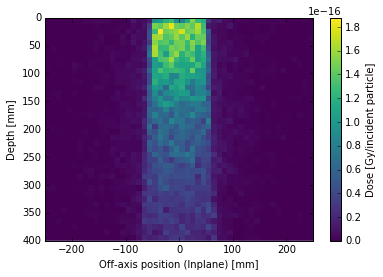

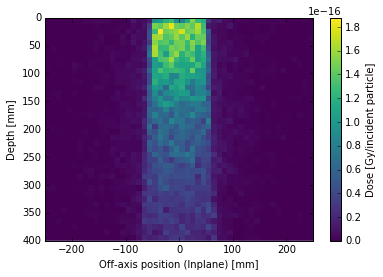

In [41]:
vlplt.plotdose('rc_23_9_10x10_v1_web.dose', xplot=25, yplot=25, zplot=6, plotdir='x', dimension=2) 

# Calculation with my phantom

## To do

I have run create_ct.py on my CT dataset to create tmp.phantom

http://radiotherapyresearchtools.com/doc/output.html#simulate-phantom-and-how-to-build-a-phantom

In [42]:
filename = 'tmp.phantom'
upload_files = {'file': open(filename, 'rb')}
# r = requests.post(url + '/upload', files=upload_files)

In [43]:
# vlplt.plotdose(filename, xplot=250 , yplot=5, zplot=250, plotdir='z')  # Can plot phantom..

In [44]:
# vlplt.plotdose('cylinder.phantom', xplot=29, yplot=59, zplot=29, plotdir='z', dimension=2)   # Can plot phantom..

# Terminate

In [45]:
instances.terminate()  # to terminate

[{'ResponseMetadata': {'HTTPHeaders': {'content-type': 'text/xml;charset=UTF-8',
    'date': 'Fri, 23 Sep 2016 14:15:48 GMT',
    'server': 'AmazonEC2',
    'transfer-encoding': 'chunked',
    'vary': 'Accept-Encoding'},
   'HTTPStatusCode': 200,
   'RequestId': 'a1a3c2f4-f599-4fc9-a161-d3b1569012f4',
   'RetryAttempts': 0},
  'TerminatingInstances': [{'CurrentState': {'Code': 32,
     'Name': 'shutting-down'},
    'InstanceId': 'i-0184035a2644292de',
    'PreviousState': {'Code': 16, 'Name': 'running'}}]}]